# Data

This notebook extracts time-series data from the following parcellation atlases and prepare them for further analysis:

In [2]:
from pathlib import Path
from tqdm.auto import tqdm

import pandas as pd
import xarray as xr
import numpy as np

from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

from src.acnets.pipeline.parcellation import Parcellation


In [3]:
BIDS_DIR = 'data/julia2018'
PARCELLATION_CACHE_DIR = 'data/julia2018/derivatives/resting_timeseries/'

In [4]:
# data

p = Parcellation(atlas_name='dosenbach2010', bids_dir=BIDS_DIR, cache_dir=PARCELLATION_CACHE_DIR)
dataset = p.fit_transform(None)


In [6]:
# H1 features

timeseries = dataset['timeseries'].to_dataframe().reset_index()

# TODO normalize across subjects

# h1 regions
h1_regions = timeseries.groupby(['subject', 'region'])['timeseries'].agg(['mean','std']).reset_index()
h1_regions['label'] = h1_regions['subject'].apply(lambda x: x[:4])
h1_regions = h1_regions.melt(id_vars=['subject','label', 'region'], value_vars=['mean','std'])

# for region in tqdm(h1_regions['region'].unique()):
#     h1_region = h1_regions.query('region == @region')
#     sns.displot(h1_region,
#                 x='value', hue='label', col='variable',
#                 kind='kde', fill=True,
#                 facet_kws=dict(sharex=False, sharey=False),
#                 height=3)
#     plt.suptitle(f'H1: {region}')
#     plt.savefig(f'outputs/figures/h1_features/regions/{region}.png')
#     plt.close()

# h1 networks
h1_networks = timeseries.groupby(['subject', 'network'])['timeseries'].agg(['mean','std']).reset_index()
h1_networks['label'] = h1_networks['subject'].apply(lambda x: x[:4])
h1_networks = h1_networks.melt(id_vars=['subject','label', 'network'], value_vars=['mean','std'])

# for network in tqdm(h1_networks['network'].unique()):
#     h1_network = h1_networks.query('network == @network')
#     sns.displot(h1_network,
#                 x='value', hue='label', col='variable',
#                 kind='kde', fill=True,
#                 facet_kws=dict(sharex=False, sharey=False),
#                 height=3)
#     plt.suptitle(f'H1: {network}')
#     plt.savefig(f'outputs/figures/h1_features/networks/{network}.png')
#     plt.close()


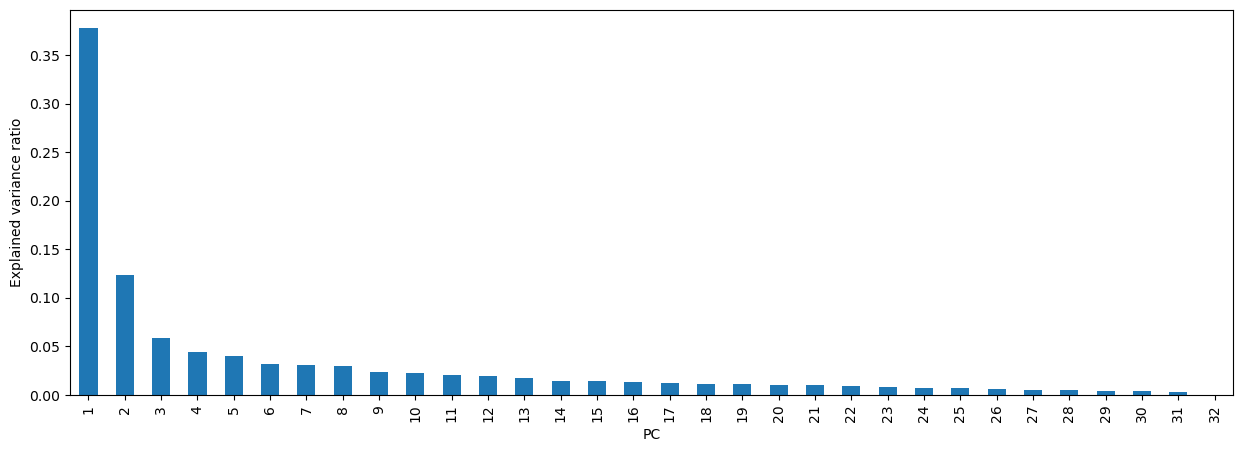

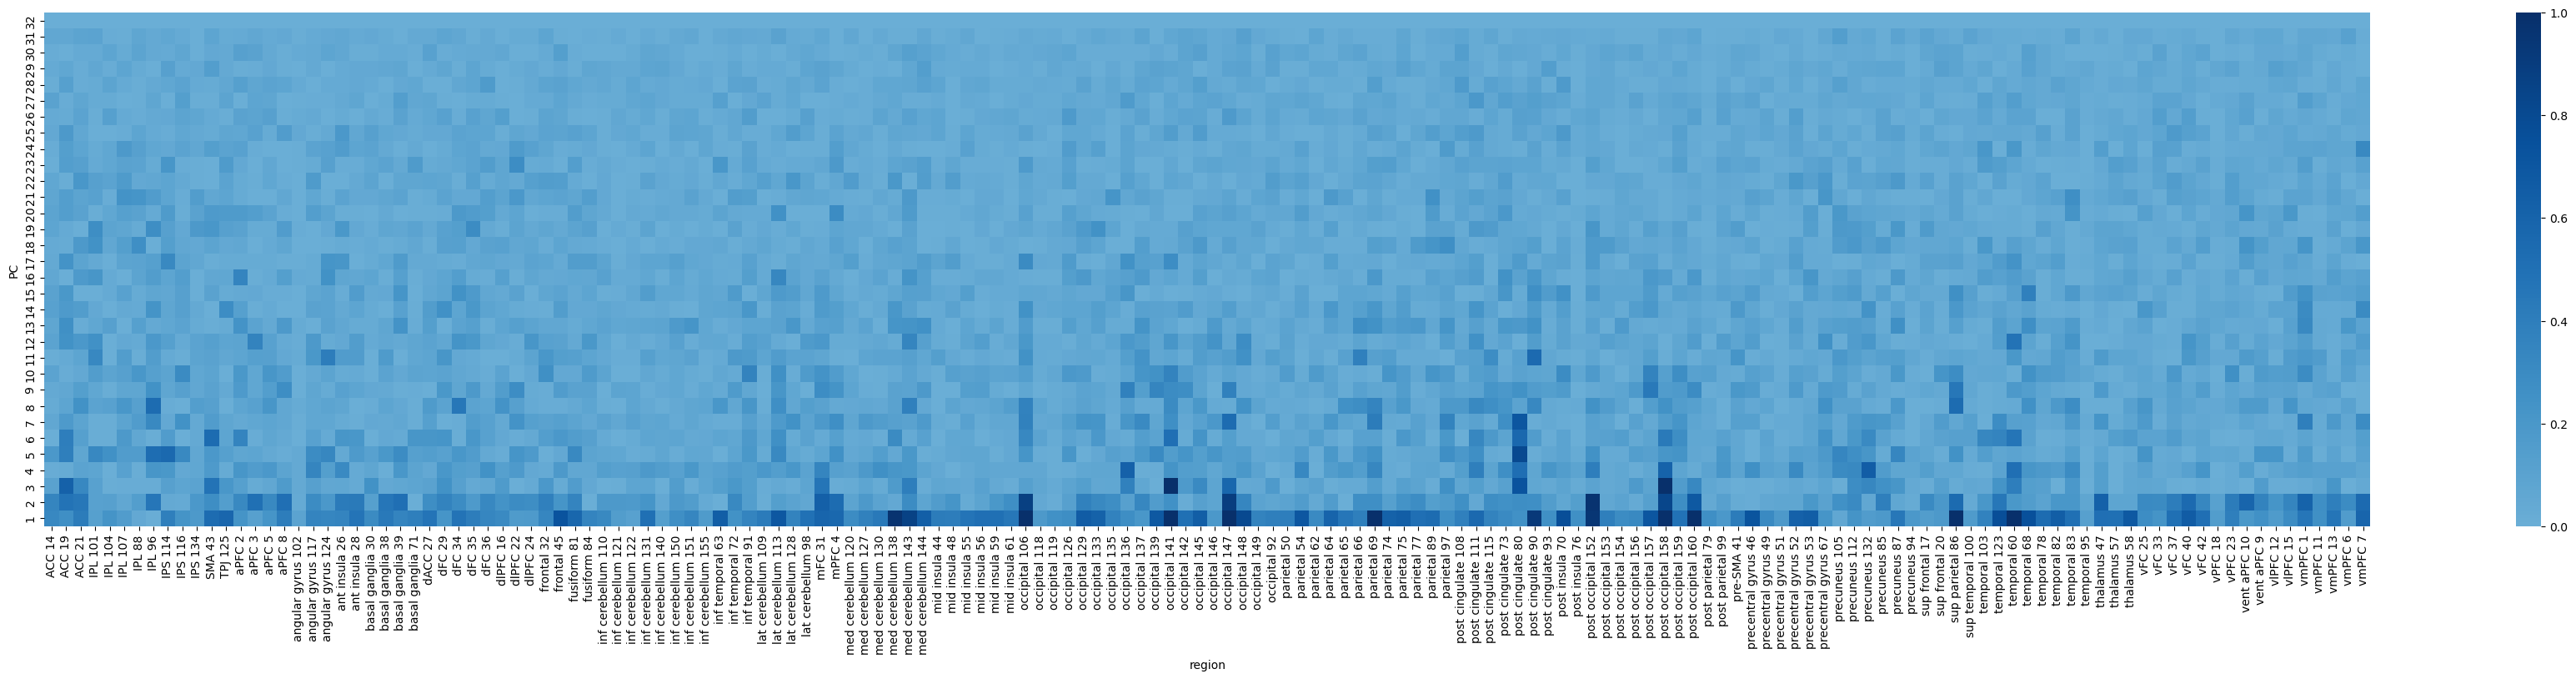

In [7]:
# H1-regions PCA

h1_regions_features = h1_regions.query('variable == "std"')
X = h1_regions_features.pivot(index='subject', columns='region', values='value')
y = X.index.to_series().apply(lambda x: x[:4]).values

pca = PCA(n_components=min(*X.shape))

X_pca = pca.fit_transform(X)

explained_variance = pd.DataFrame(pca.explained_variance_ratio_,
                                  index=range(1, pca.n_components_+1),
                                  columns=['explain_variance_ratio'])
explained_variance.plot.bar(figsize=(15, 5), legend=False)
plt.xlabel('PC')
plt.ylabel('Explained variance ratio')
plt.show()

# H2 features
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings = pd.DataFrame(loadings, index=X.columns, columns=range(1, pca.n_components_+1))

loadings = loadings.abs()
fig, ax = plt.subplots(figsize=(45, 8))
g = sns.heatmap(loadings.T, cmap='Blues',
                center=0, vmin=0, vmax=1, ax=ax)
g.invert_yaxis()
g.set_ylabel('PC')
plt.show()


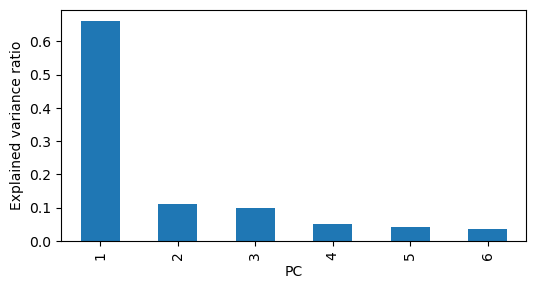

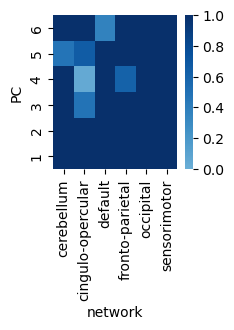

In [8]:
# H1-networks PCA

h1_networks_features = h1_networks.query('variable == "std"')
X = h1_networks_features.pivot(index='subject', columns='network', values='value')
y = X.index.to_series().apply(lambda x: x[:4]).values

pca = PCA(n_components=min(*X.shape))

X_pca = pca.fit_transform(X)

explained_variance = pd.DataFrame(pca.explained_variance_ratio_,
                                  index=range(1, pca.n_components_+1),
                                  columns=['explain_variance_ratio'])
explained_variance.plot.bar(figsize=(6, 3), legend=False)
plt.xlabel('PC')
plt.ylabel('Explained variance ratio')

# H2 features
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings = pd.DataFrame(loadings, index=X.columns, columns=range(1, pca.n_components_ + 1))

loadings = loadings.abs()
fig, ax = plt.subplots(figsize=(2, 2))
g = sns.heatmap(loadings.T, cmap='Blues',
                center=0, vmin=0, vmax=1, ax=ax)
g.invert_yaxis()
g.set_ylabel('PC')
plt.show()
